# **Cifar-10 image classification model using NN**

The dataset: 
The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

(1) Import libraries and load the necessary data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Sequential

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train[:10000]
y_train = y_train[:10000]

X_test = X_test[:1000]
y_test = y_test[:1000]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 1)
X_test shape: (1000, 32, 32, 3)
y_test shape: (1000, 1)


(2) Visualize the data

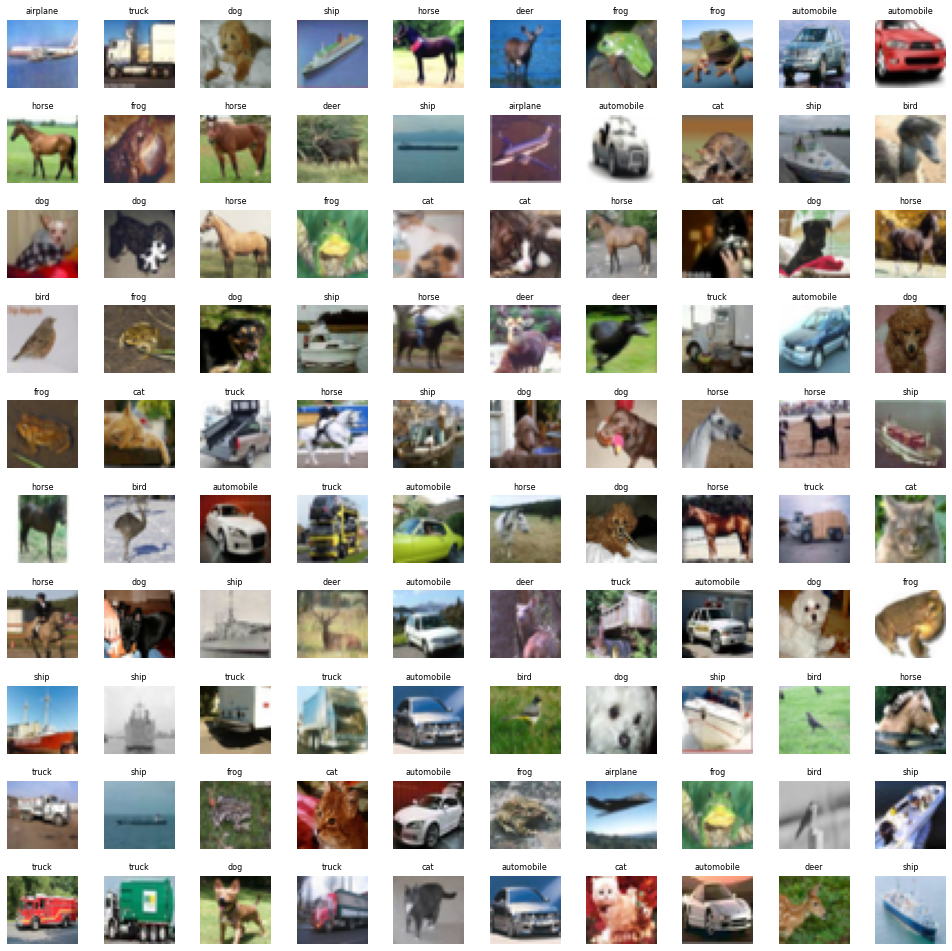

In [27]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']


fig, axes = plt.subplots(10, 10, figsize = (17,17))
axes = axes.ravel() 
n_train = len(X_train) 

# Visulize random pictures from the dataset
for i in np.arange(0, 100): 
    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

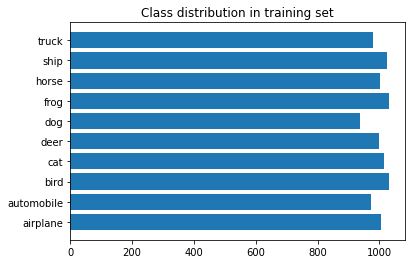

In [28]:
# Plot amount of unique values in training set
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(labels, counts)
plt.title('Class distribution in training set')
plt.show()

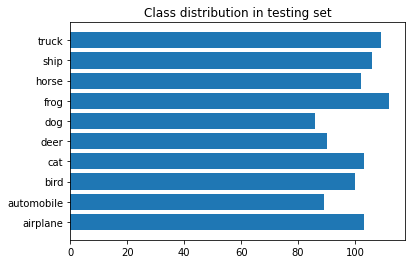

In [29]:
# Plot amount of unique values in testing set
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(labels, counts)
plt.title('Class distribution in testing set')
plt.show()

(3) Data preprocessing

In [30]:
def preprocess_data(X_train, X_test, y_cat_train, y_cat_test):
    # Scale the data to range [0,1] for better convergence
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Transform target variable into one-hot encoding (for categorical crossentropy)
    y_cat_train = to_categorical(y_train, 10)
    y_cat_test = to_categorical(y_test, 10)
    return X_train, X_test, y_cat_train, y_cat_test

(4) Build the model

In [31]:
# Build the CNN model
def build_model(input_shape, kernel_size):
    model = models.Sequential()

    # Convolutional Layer Block 1
    model.add(layers.Conv2D(32, kernel_size, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Layer Block 2
    model.add(layers.Conv2D(64, kernel_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Layer Block 3
    model.add(layers.Conv2D(128, kernel_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, kernel_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer

    return model

input_shape = (32, 32, 3)
kernel_size = (3, 3)
model = build_model(input_shape, kernel_size)
model.summary()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)       

(5) Add Early Stopping (it wasn't used in this case)

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

(6) Data Augmentation for more robust model

In [33]:
X_train, X_test, y_cat_train, y_cat_test = preprocess_data(X_train, X_test, y_train, y_test)
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator, 
              epochs=20,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/20
312/312 [==============================] - 54s 169ms/step - loss: 1.9621 - accuracy: 0.2931 - precision: 0.4680 - recall: 0.0822 - val_loss: 2.9532 - val_accuracy: 0.1150 - val_precision: 0.2415 - val_recall: 0.0570
Epoch 2/20
312/312 [==============================] - 67s 215ms/step - loss: 1.6909 - accuracy: 0.3749 - precision: 0.5768 - recall: 0.1421 - val_loss: 1.5368 - val_accuracy: 0.4310 - val_precision: 0.6080 - val_recall: 0.2280
Epoch 3/20
312/312 [==============================] - 82s 262ms/step - loss: 1.5600 - accuracy: 0.4327 - precision: 0.6240 - recall: 0.1964 - val_loss: 1.4652 - val_accuracy: 0.4460 - val_precision: 0.6650 - val_recall: 0.2680
Epoch 4/20
312/312 [==============================] - 67s 215ms/step - loss: 1.4502 - accuracy: 0.4727 - precision: 0.6544 - recall: 0.2644 - val_loss: 1.6150 - val_accuracy: 0.4360 - val_precision: 0.5772 - val_recall: 0.2840
Epoch 5/20
312/312 [==============================] - 70s 225ms/step - loss: 1.3778 - accura

Plot results from training

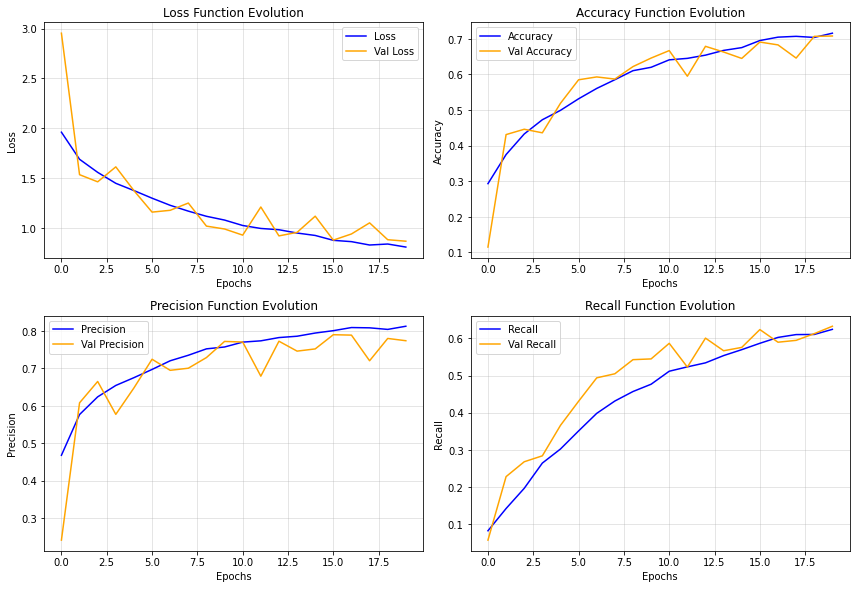

In [34]:
plt.figure(figsize=(12, 16))

# Loss
plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss', color='blue')
plt.plot(r.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss Function Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.4)

# Accuracy
plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy', color='blue')
plt.plot(r.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy Function Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.4)

# Precision
plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='Precision', color='blue')
plt.plot(r.history['val_precision'], label='Val Precision', color='orange')
plt.title('Precision Function Evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(alpha=0.4)

# Recall
plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='Recall', color='blue')
plt.plot(r.history['val_recall'], label='Val Recall', color='orange')
plt.title('Recall Function Evolution')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

32/32 [==============================] - 1s 36ms/step - loss: 0.8708 - accuracy: 0.7080 - precision: 0.7738 - recall: 0.6330
Test Accuracy : 70.80%


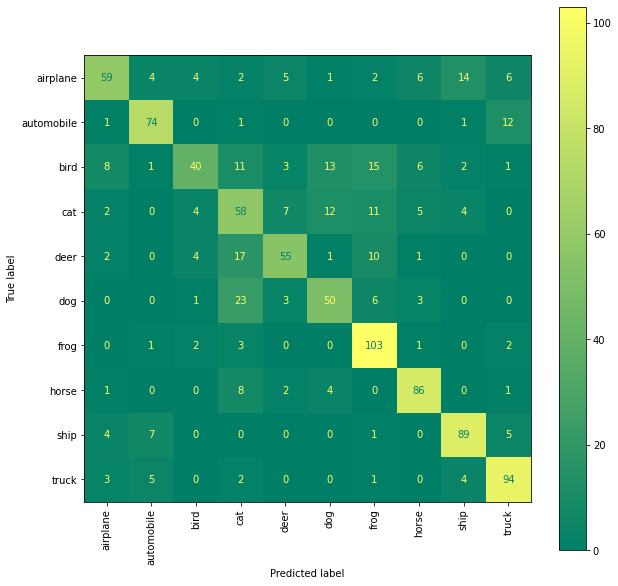

In [35]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64       103
           1       0.80      0.83      0.82        89
           2       0.73      0.40      0.52       100
           3       0.46      0.56      0.51       103
           4       0.73      0.61      0.67        90
           5       0.62      0.58      0.60        86
           6       0.69      0.92      0.79       112
           7       0.80      0.84      0.82       102
           8       0.78      0.84      0.81       106
           9       0.78      0.86      0.82       109

    accuracy                           0.71      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.71      0.70      1000



Predict some image

 Image 100 is [4]
The model predict that image 100 is 4


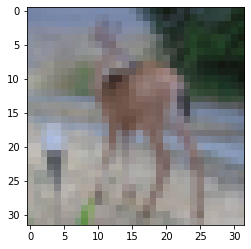

In [37]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    

Plot the first X test images, their predicted labels, and the true labels. Color correct predictions in blue and incorrect predictions in red.

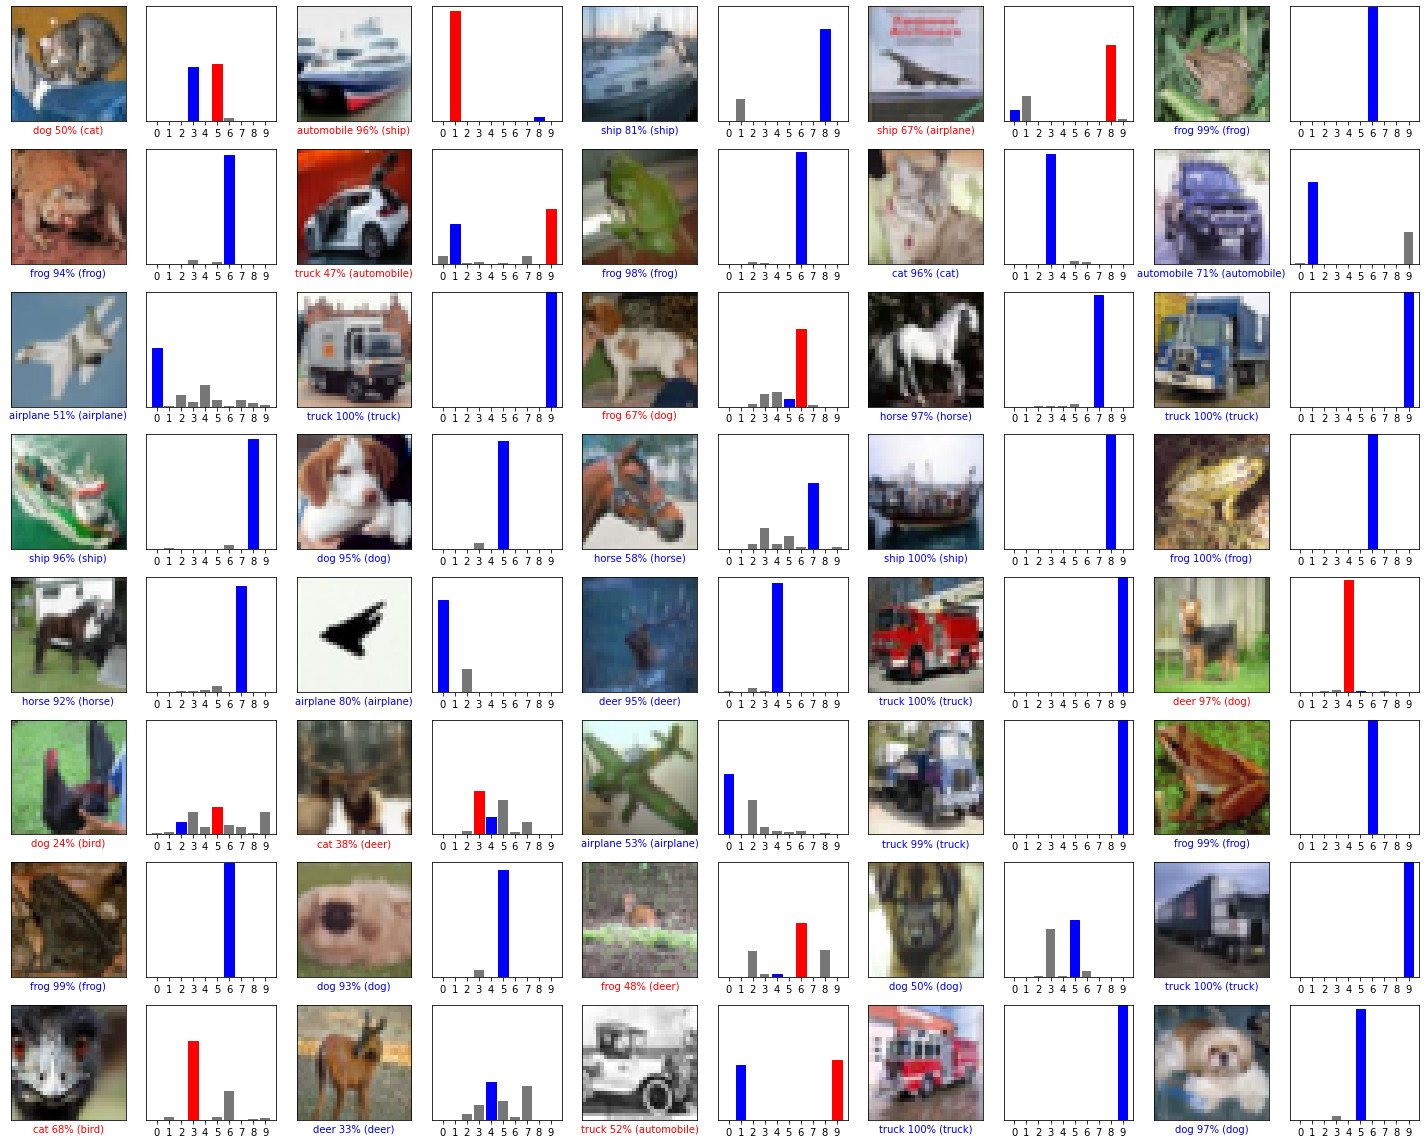

In [ ]:
predictions = model.predict(X_test)

num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()